## Import Library dan Muat Dataset


In [1]:
import pandas as pd
import numpy as np
import kagglehub
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Download dataset (sudah disiapkan oleh user di notebook)
path = kagglehub.dataset_download("prepinstaprime/europe-bike-store-sales")
csv_path = os.path.join(path, 'Sales.csv')
df = pd.read_csv(csv_path)
print('Dataset shape:', df.shape)
df.head()

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset shape: (113036, 18)


,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2013-11-26,26,November,2013,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
1,2015-11-26,26,November,2015,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
2,2014-03-23,23,March,2014,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,23,45,120,1366,1035,2401
3,2016-03-23,23,March,2016,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,20,45,120,1188,900,2088
4,2014-05-15,15,May,2014,47,Adults (35-64),F,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,4,45,120,238,180,418


## Pra-pemrosesan data dan Penentuan Target


In [2]:
# Salin dan pra-pemrosesan dasar

df_proc = df.copy()
if 'Date' in df_proc.columns:
    df_proc['Date'] = pd.to_datetime(df_proc['Date'], errors='coerce')
    df_proc['Month_Num'] = df_proc['Date'].dt.month
    df_proc['Day_of_Week'] = df_proc['Date'].dt.dayofweek
    df_proc['Day_Num'] = df_proc['Date'].dt.day

# Tentukan kolom target (sesuaikan jika nama berbeda di dataset Anda)
target_col = 'Age_Group'
if target_col not in df_proc.columns:
    raise ValueError(f"Kolom target '{target_col}' tidak ditemukan di dataset. Sesuaikan nama kolom target di notebook.")

# Buang baris tanpa target
df_proc = df_proc.dropna(subset=[target_col])

# Factorize target menjadi label numerik
y, class_names = pd.factorize(df_proc[target_col])
print('Jumlah kelas target:', len(class_names))
print('Nama kelas target:', list(class_names))

Jumlah kelas target: 4
Nama kelas target: ['Youth (<25)', 'Adults (35-64)', 'Young Adults (25-34)', 'Seniors (64+)']


## Feature engineering: numerik dan kategori



In [3]:
# Pilih fitur numerik dan beberapa kategori yang relevan

num_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_proc.select_dtypes(include=['object','category']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)

# Buat grouping sederhana untuk Country jika ada
if 'Country' in df_proc.columns:
    top_n = 10
    top_countries = df_proc['Country'].value_counts().nlargest(top_n).index
    df_proc['Country_grp'] = df_proc['Country'].where(df_proc['Country'].isin(top_countries), other='Other')
    if 'Country' in cat_cols:
        cat_cols.append('Country_grp')

# Pilih kolom kategori yang akan digunakan
use_cat = [c for c in ['Customer_Gender', 'Product_Category', 'Sub_Category', 'Country_grp'] if c in df_proc.columns]

# One-hot encode kategori
if len(use_cat) > 0:
    df_cat = pd.get_dummies(df_proc[use_cat], drop_first=True)
else:
    df_cat = pd.DataFrame(index=df_proc.index)

# Pilih numerik yang relevan (exclude target)
num_select = [c for c in num_cols if c not in [target_col]]
df_num = df_proc[num_select].reset_index(drop=True)

# Gabungkan fitur numerik dan kategori
X_df = pd.concat([df_num, df_cat.reset_index(drop=True)], axis=1)
# Isi missing numeric dengan median
X_df = X_df.fillna(X_df.median(numeric_only=True))

# Simpan kolom untuk referensi saat membuat sample baru
X_columns = X_df.columns.copy()
X = X_df.values
print('Ukuran fitur (X):', X.shape)
print('Ukuran target (y):', y.shape)

Ukuran fitur (X): (113036, 36)
Ukuran target (y): (113036,)


## Membagi dataset menjadi Training dan Test



In [4]:
# Bagi data train/test (stratify untuk menjaga distribusi kelas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (90428, 36) Test shape: (22608, 36)


## Scaling dan Pelatihan Gaussian Naive Bayes


In [5]:
# Scaling fitur numerik menggunakan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Latih Gaussian Naive Bayes
nbc = GaussianNB()
nbc.fit(X_train_scaled, y_train)

# Prediksi pada test set
y_pred = nbc.predict(X_test_scaled)
print('Akurasi Model (test):', round(accuracy_score(y_test, y_pred),4))

Akurasi Model (test): 0.8792


## Evaluasi Performa Model


Akurasi Model: 0.8792

Confusion Matrix:
[[3124   69  348   25]
 [   0 9800  525  840]
 [ 322  484 6827   98]
 [   0   19    0  127]]


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3566
           1       0.94      0.88      0.91     11165
           2       0.89      0.88      0.88      7731
           3       0.12      0.87      0.21       146

    accuracy                           0.88     22608
   macro avg       0.71      0.88      0.72     22608
weighted avg       0.91      0.88      0.89     22608



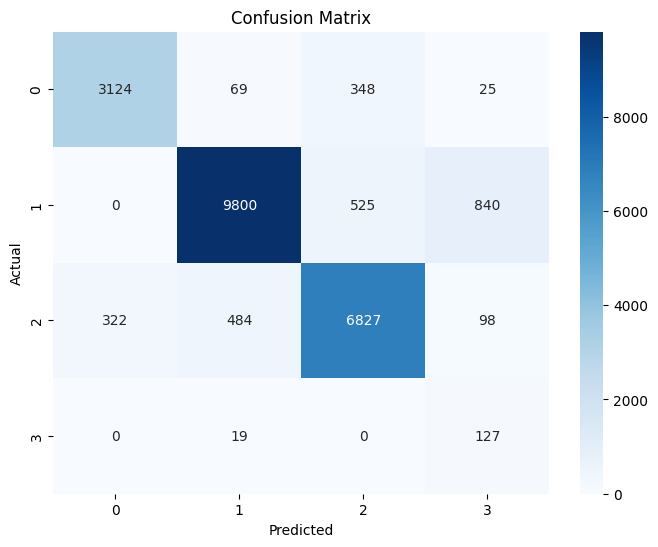

In [7]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy:.4f}\n")

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Contoh Prediksi Single-Sample (Helper & Example)


In [8]:
def prepare_single_input(row_dict, X_columns, scaler, df_reference):
    df_row = pd.DataFrame([row_dict])
    # Isi missing numeric dengan median referensi
    for col in df_row.select_dtypes(include=[np.number]).columns:
        if df_row[col].isna().any():
            if col in df_reference.columns and np.issubdtype(df_reference[col].dtype, np.number):
                df_row[col] = df_row[col].fillna(df_reference[col].median())
            else:
                df_row[col] = df_row[col].fillna(0)
    for col in df_row.select_dtypes(exclude=[np.number]).columns:
        if df_row[col].isna().any():
            if col in df_reference.columns:
                df_row[col] = df_row[col].fillna(df_reference[col].mode().iloc[0])
            else:
                df_row[col] = df_row[col].fillna('')
    # One-hot encode dan reindex ke kolom X yang dipakai saat training
    df_enc = pd.get_dummies(df_row, drop_first=True)
    df_enc = df_enc.reindex(columns=X_columns, fill_value=0)
    arr = scaler.transform(df_enc)
    return arr

# Contoh sample (sesuaikan kolom sesuai dataset)
sample = {}
if 'Customer_Age' in df_proc.columns:
    sample['Customer_Age'] = 30
if 'Order_Quantity' in df_proc.columns:
    sample['Order_Quantity'] = 2
if 'Unit_Price' in df_proc.columns:
    sample['Unit_Price'] = 120.0
if 'Customer_Gender' in df_proc.columns:
    sample['Customer_Gender'] = df_proc['Customer_Gender'].mode().iloc[0]
if 'Country' in df_proc.columns:
    sample['Country'] = df_proc['Country'].mode().iloc[0]

# Coba prediksi
try:
    X_single = prepare_single_input(sample, X_columns, scaler, df_proc)
    pred = nbc.predict(X_single)[0]
    print('Prediksi label (numeric):', pred)
    print('Prediksi kelas (name):', class_names[pred])
except Exception as e:
    print('Tidak dapat memprediksi sample:', e)
    print('Periksa kolom sample sesuai dataset.')


Prediksi label (numeric): 0
Prediksi kelas (name): Youth (<25)


C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
